# PEDS Tutorial

# Import Packages

In [1]:

import os
import sys
proj_path = os.path.dirname(os.path.abspath('.'))
sys.path.append(proj_path)

In [2]:
from src.DataGenerator import DataGenerator as DG
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from src.DiffusionModel import DiffusionModel as DM
import config 
SEED=42

# Define Parameters

In [4]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
params=config.params
data_dir = os.path.join('..','data')
grid_width = params['width'] / params['num_wells']
params['grid_width'] = grid_width
anchors = np.linspace(0, params['width'], params['num_wells'] + 1)[:params['num_wells']] + (
            params['grid_width'] / 2)
params['anchors'] = anchors

lengths_dir = os.path.join(data_dir, 'lengths')
y_dir = os.path.join(data_dir, 'y')
k_dir = os.path.join(data_dir, 'k')
D_dir=os.path.join(data_dir,'D')
print(f'device:{device}')

dg = DG(params)
geo_list = dg.generate_geo(seed=SEED)
lengths_array=np.load(lengths_dir+'.npy')
y_array=np.load(y_dir+'.npy')
k_array=np.load(k_dir+'.npy')
D_array=np.load(D_dir+'.npy')


device:cpu


Generating data: 100%|██████████| 1000/1000 [00:00<00:00, 64770.89it/s]


# Check the Solver's Result

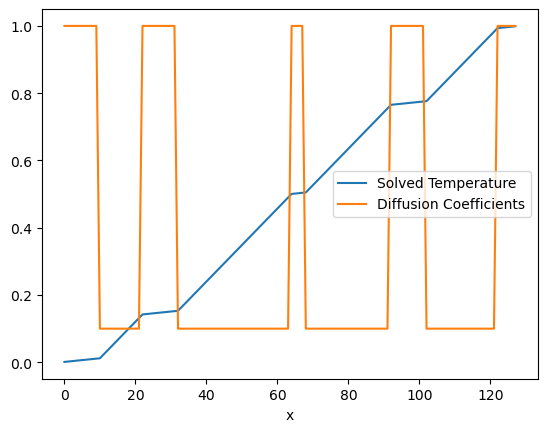

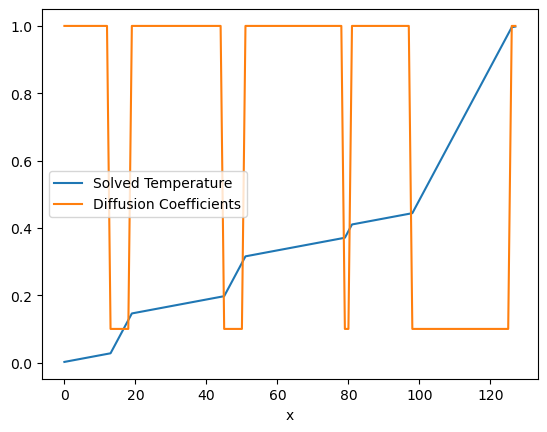

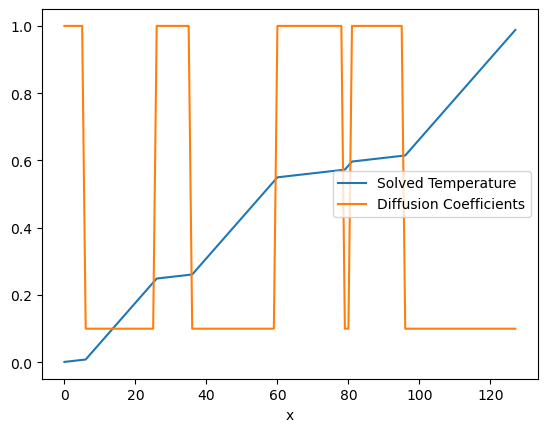

In [8]:
check_num=3
for i in range(check_num):
    plt.plot(y_array[i],label='Solved Temperature')
    plt.plot(D_array[i],label='Diffusion Coefficients')
    plt.xlabel('x')
    plt.legend()
    plt.show()

# Split Data

In [9]:
y_train, y_temp, lengths_train, lengths_temp, k_train, k_temp = train_test_split(
    y_array, lengths_array, k_array, train_size=params['num_train'], random_state=SEED
)

y_test, y_val, lengths_test, lengths_val, k_test, k_val = train_test_split(
    y_temp, lengths_temp, k_temp, train_size=params['num_test'], test_size=params['num_val'], random_state=SEED
)

# Define Model

In [10]:
input_dim=lengths_array.shape[1]
dm=DM(input_dim,params)
dm.load_data(lengths_train,k_train,lengths_val,k_val)

Training and validation data loaded successfully on cpu.


# Load Weights and Predict

In [12]:
weight_path=os.path.join('..','weights')
w_list=[0,0.3,0.6,0.9,0.99]
k_pred_list=[]

for w in w_list:
    params['w']=w
    dm.load_state_dict(torch.load(os.path.join(weight_path,f'w={w}_LF_N={params['LF_N']}.pt')))
    k_pred_list.append(dm.forward(torch.from_numpy(lengths_test).float().to(device),params))


C:\Users\cur_cur_sheep\AppData\Local\Temp\ipykernel_12380\907290801.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dm.load_state_dict(torch.load(os.path.join(weight_pat

# Evaluation

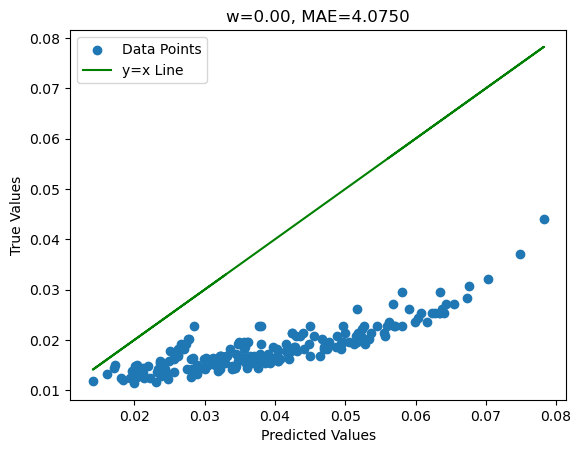

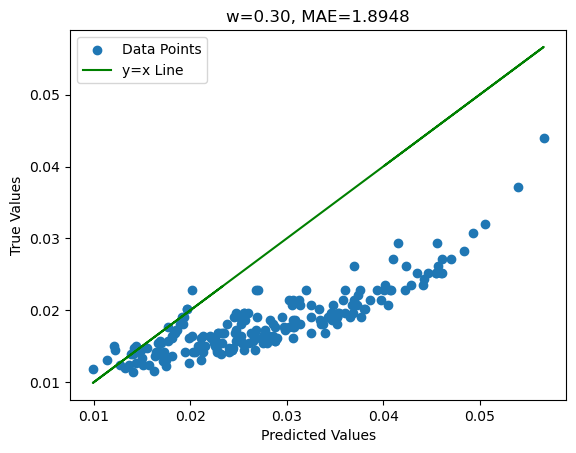

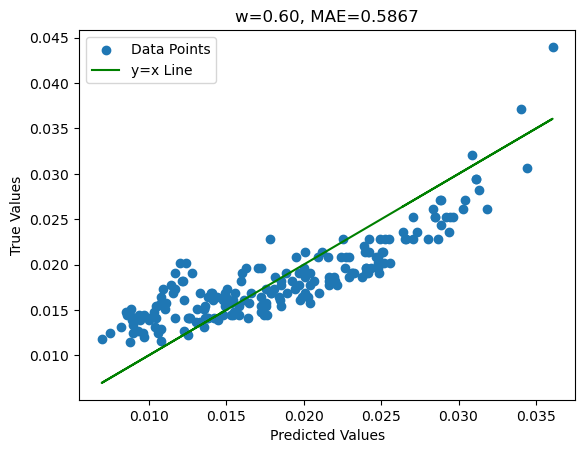

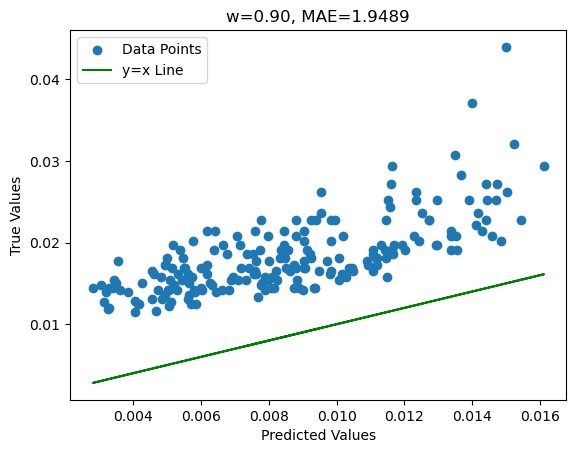

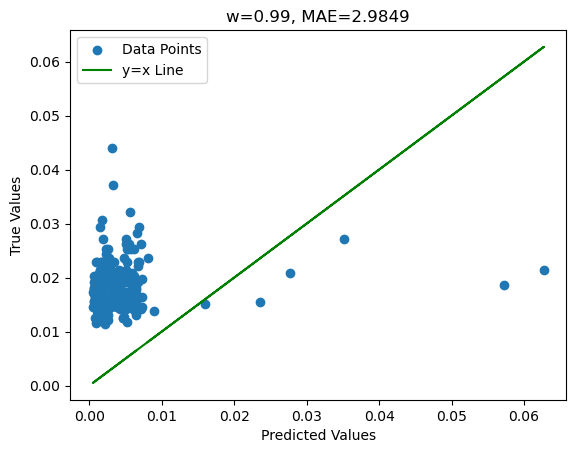

In [13]:
for i, w in enumerate(w_list):
    k_pred = np.array(k_pred_list[i].detach() )
    
    mse = np.sum(np.abs(k_test - k_pred))
    plt.scatter(k_pred, k_test, label='Data Points')
    plt.plot(k_pred, k_pred, c='g', label='y=x Line')
    
    # 添加标题，包含 w 和 Spearman 相关系数
    plt.title(f'w={w:.2f}, MAE={mse:.4f}')
    
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.legend()
    plt.show()